In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from models import LocallyWeightedCNP, CNP
from data import TwoSkillsDataset

In [ ]:
if not os.path.exists("out"):
    os.makedirs("out")

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [ ]:
trainset = TwoSkillsDataset(N=50)
num_trajs, t_steps = trainset.N, trainset.data.shape[1]
x_train, y_train = trainset.data[:trainset.N, :, [0]], trainset.data[:trainset.N, :, [1, 2]]
x_val, y_val = trainset.data[trainset.N:, :, [0]], trainset.data[trainset.N:, :, [1, 2]]
d_x, d_y = x_train.shape[-1], y_train.shape[-1]

In [ ]:
model = LocallyWeightedCNP((d_x, d_y)).to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def predict_model(observations, x_target, plot=True, step=-1):    
    with torch.no_grad():
        y_pred, std_pred = model(observations, x_target)
    
    if plot:
        fig = plt.figure(figsize=(5,5))
        for j in range(num_trajs):
            plt.plot(y_train[j, :, 0].cpu(), y_train[j, :, 1].cpu(), c="b", alpha=0.1)
        idx = 0
        for _ in range(100):
            y_sample = D.Normal(y_pred, std_pred).sample()
            plt.scatter(y_sample[0, :, 0].cpu(), y_sample[0, :, 1].cpu(), c=torch.linspace(0, 1, 200).tolist(), alpha=0.1, s=10, cmap="jet")
        # plt.errorbar(x_val[idx, :, 0].cpu(), y_pred[idx, :, i].cpu(), yerr=std_pred[idx, :, i].cpu(), color = 'black', alpha=0.4)
        plt.scatter(observations[idx, [0, -1], 1].cpu(), observations[idx, [0, -1], 2].cpu(), marker="X", color='black')
        plt.savefig(f'out/s{step}_val.png')
        plt.close()
    return y_pred, std_pred

(-1.0, 7.0)

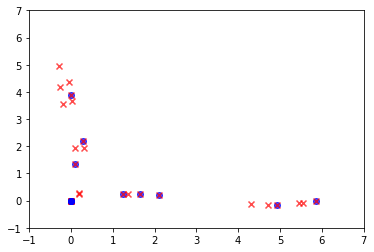

In [ ]:
x_t, y_t, x_mask, y_mask = trainset.get_sample(5, max_context=5, max_target=5)
for i in range(5):
    plt.scatter(x_t[i, :, 1], x_t[i, :, 2], marker="o", c="b", alpha=0.7)
    plt.scatter(y_t[i, :, 1], y_t[i, :, 2], marker="x", c="r", alpha=0.7)
plt.xlim((-1, 7))
plt.ylim((-1, 7))

In [ ]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
loss_inform_checkpoint = 100000
plot_checkpoint = 10000
validation_checkpoint = 1000
validation_error = 9999999

val_observation = torch.zeros(2, 1, d_x+d_y, device=device)
nof_val_trajs = x_val.shape[0]

for step in range(5000000):
    x_t, y_t, x_m, y_m = trainset.get_sample(10, max_context=5, max_target=10)
    x_t = x_t.to(device)
    y_t = y_t.to(device)
    x_m = x_m.to(device)
    y_m = y_m.to(device)
    optimizer.zero_grad()
    loss = model.nll_loss(x_t, y_t[..., :1], y_t[..., 1:])
    loss.backward()
    optimizer.step()
    if step % loss_inform_checkpoint == 0:
        print(f'Step: {step}')
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data.cpu())
        smooth_losses[-1] += loss.data.cpu()/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        xy_val = torch.cat([x_val, y_val], dim=-1)
        current_error = model.nll_loss(xy_val[:, [0, -1]].to(device), x_val.to(device), y_val.to(device))  # only give the initial and the last timestep
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), 'cnmp_best_validation.h5')
            print(f'Step: {step}. New validation best. Error: {current_error}')
        
    if step % plot_checkpoint == 0:        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)), smooth_losses)
        plt.savefig(f'out/{step}.png')
        plt.close()
        
        #plotting validation cases
        predict_model(torch.tensor([[[0.0, 0.0, 6.0], [1.0, 0.0, 0.0]]], device="cuda"), x_val[:1].to(device), plot=True, step=step)
        predict_model(torch.tensor([[[0.0, 0.0, 0.0], [1.0, 6.0, 0.0]]], device="cuda"), x_val[:1].to(device), plot=True, step=step+1)
        predict_model(torch.tensor([[[0.0, 0.0, 6.0], [1.0, 6.0, 0.0]]], device="cuda"), x_val[:1].to(device), plot=True, step=step+2)
        
        if step!=0:
            smooth_losses.append(0)
# print('Finished Training')

Step: 0
Step: 0. New validation best. Error: 6.415947437286377
Step: 1000. New validation best. Error: 1.4572538137435913
Step: 2000. New validation best. Error: 1.4322993755340576
Step: 3000. New validation best. Error: 1.4234094619750977
Step: 11000. New validation best. Error: 0.4124543070793152
Step: 13000. New validation best. Error: 0.3109584450721741
Step: 15000. New validation best. Error: 0.01848081313073635
Step: 16000. New validation best. Error: -0.3572978675365448
Step: 17000. New validation best. Error: -0.6313767433166504
Step: 24000. New validation best. Error: -0.7300012707710266
Step: 25000. New validation best. Error: -1.0030810832977295
Step: 30000. New validation best. Error: -1.1597962379455566
Step: 39000. New validation best. Error: -1.4862420558929443
Step: 100000
Step: 200000
